# Example: Static inverse free-boundary equilibrium calculations

---

This example notebook shows how to use FreeGSNKE to solve **static inverse** free-boundary Grad-Shafranov (GS) problems. 

In the **inverse** solve mode we seek to estimate the active poloidal field coil currents using user-defined constraints (e.g. on isoflux, x-point, and psi values) and plasma current density profiles for a desired equilibrium shape. 

Note that during this solve, currents are **not** found in any specified passive structures. 

Below, we illustrate how to use the solver for both diverted and limited plasma configurations in a **MAST-U-like tokamak** using stored pickle files containing the machine description. These machine description files partially come from the FreeGS repository and are not an exact replica of MAST-U.

### The static free-boundary Grad-Shafranov problem

Here we will outline the **static free-boundary** GS problem that is solved within both the **forward** and **inverse** solvers, though we encourage you to see [Pentland et al. (2024)](https://arxiv.org/abs/2407.12432) for more details. 

Using a cylindrical coordinate system $(R,\phi,Z)$, the aim is to solve the GS equation:

$$ \Delta^* \psi \equiv \left( \frac{\partial^2}{\partial R^2} - \frac{1}{R} \frac{\partial}{\partial R} + \frac{\partial^2}{\partial Z^2} \right) \psi = -\mu_0 R J_{\phi}(\psi, R, Z), \qquad (R,Z) \in \Omega, $$

for the poloidal flux $\psi(R,Z)$ (which here has units Weber/$2\pi$) in the rectangular computational domain $\Omega$. The flux has contributions from both the plasma and the coils (metals) such that $\psi = \psi_p + \psi_c$. This flux defines the toridal current density $J_{\psi} = J_p(\psi,R,Z) + J_c(R,Z)$, also containing a contribution from both the plasma and coils, respectively. We have the plasma current density (only valid in the core plasma region $\Omega_p$):

$$ J_p(\psi,R,Z) = R \frac{\mathrm{d}p}{\mathrm{d}\psi} +\frac{1}{\mu_0 R} F \frac{\mathrm{d} F}{\mathrm{d} \psi}, \qquad (R,Z) \in \Omega_p, $$

where $p(\psi)$ is the plasma pressure profile and $F(\psi)$ is the toroidal magnetic field profile. The current density generated by the ($N$) active coils and passive structures is given by:

$$ J_c(R,Z) = \sum_{j=1}^{N} \frac{I^c_j(R,Z)}{A_j^c}, \qquad (R,Z) \in \Omega, \quad \text{where} \quad I_j^c(R,Z) = 
\begin{cases} 
    I_j^c & \text{if } (R,Z) \in \Omega_j^c, \\ 
    0 & \text{elsewhere}.
\end{cases}.$$

This makes use of the current $I^c_j$ in each metal and its cross-sectional area $A^c_j$ (the domain of each metal is denoted by $\Omega_j^c$).

To complete the problem, we need the integral (Dirichlet) free-boundary condition:

$$ \psi(R,Z) = \int_{\Omega} G(R,Z;R',Z') J_{\phi}(\psi, R',Z') \ \mathrm{d}R' \mathrm{d}Z', \qquad (R,Z) \in \partial \Omega, $$

where $G$ is the (known) Green's function for the elliptic operator above.

### Import packages
We'll now go through the steps required to solve the **inverse** problem in FreeGSNKE. 

In [1]:
import os
import matplotlib.pyplot as plt
import freegs4e
import numpy as np

### Create the machine object

First, we build the machine object. This is done using the pickle files saved in the "machine_configs/MAST-U" directory. 

FreeGSNKE requires the following environment variables in order to build the machine:
- `ACTIVE_COILS_PATH`
- `PASSIVE_COILS_PATH`
- `WALL_PATH`
- `LIMITER_PATH`
- `PROBE_PATH` (not required here).

In [2]:
# set paths
os.environ["ACTIVE_COILS_PATH"] = f"../machine_configs/MAST-U/MAST-U_like_active_coils.pickle"
os.environ["PASSIVE_COILS_PATH"] = f"../machine_configs/MAST-U/MAST-U_like_passive_coils.pickle"
os.environ["WALL_PATH"] = f"../machine_configs/MAST-U/MAST-U_like_wall.pickle"
os.environ["LIMITER_PATH"] = f"../machine_configs/MAST-U/MAST-U_like_limiter.pickle"

In [3]:
# Now the machine can actually be built:
from freegsnke import build_machine
tokamak = build_machine.tokamak()

No probe configuration is provided


Text(10.027777777777777, 0.5, 'Height, $Z$ [m]')

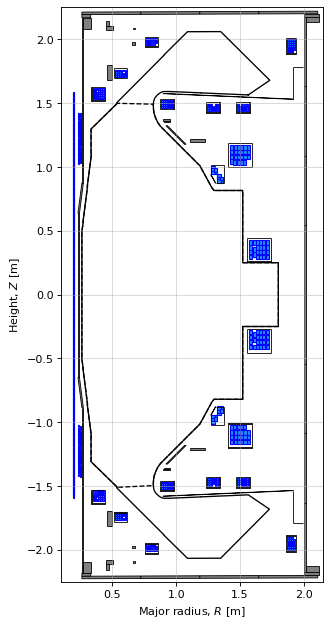

In [4]:
# plot the machine
fig1, ax1 = plt.subplots(1, 1, figsize=(4, 8), dpi=80)
plt.tight_layout()

tokamak.plot(axis=ax1, show=False)
ax1.plot(tokamak.limiter.R, tokamak.limiter.Z, color='k', linewidth=1.2, linestyle="--")
ax1.plot(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, linestyle="-")

ax1.grid(alpha=0.5)
ax1.set_aspect('equal')
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)
ax1.set_xlabel(r'Major radius, $R$ [m]')
ax1.set_ylabel(r'Height, $Z$ [m]')

### Instantiate an equilibrium

We are now ready to build a plasma equilibrium object for our tokamak. This is done using the `freegs4e.Equilibrium` class, which implicitly defines the rectangular domain of the solver as well as the grid resolution.

`Equilibrium` has sensible defaults, but it is recommended to define the radial and vertical domain of the grid using the `Rmin`, `Rmax`, `Zmin` and `Zmax` parameters, as well as the grid resolution in the radial and vertical directions with the `nx` and `ny` parameters. The grid will be initialised using fourth-order finite differences. 

A tokamak object should be supplied to the `tokamak` parameter to assign the desired machine to the equilibrium.

If available, an initial plasma flux array (dimensions `nx` x `ny`) can be provided via the `psi` parameter (commented out in the following code). This can be used as an initial guess for the plasma flux $\psi_p$, noting that the total flux is given by $\psi(R,Z) = \psi_p(R,Z) + \psi_c(R,Z)$ where $\psi_c$ is the flux produced by currents in the active coils and passive structures. 

The `eq` object will store a lot of important information and derived quantites once the equilibrium has been calculated (see future notebook on this). 

In [5]:
from freegsnke import equilibrium_update

eq = equilibrium_update.Equilibrium(
    tokamak=tokamak,      # provide tokamak object
    Rmin=0.1, Rmax=2.0,   # radial range
    Zmin=-2.2, Zmax=2.2,  # vertical range
    nx=65,                # number of grid points in the radial direction (needs to be of the form (2**n + 1) with n being an integer)
    ny=129,               # number of grid points in the vertical direction (needs to be of the form (2**n + 1) with n being an integer)
    # psi=plasma_psi
)

### Instantiate a profile object

We can now instatiate a profile object that contains the chosen parameterisation of the toroidal plasma current density $J_p$ (i.e. on right hand side of the GS equation). We can then set the paramters for the chosen current density profiles. 

A number of commonly used profile parameterisations exist in FreeGSNKE, including:
- `ConstrainPaxisIp`
- `ConstrainBetapIp`
- `Fiesta_Topeol`
- `Lao85`
- `ProfilesPprimeFfprime`
- `TensionSpline`

In this notebook, we will make use of the `ConstrainPaxisIp` (and `ConstrainBetapIp`) profiles (see [Jeon (2015)](https://link.springer.com/article/10.3938/jkps.67.843)). Others will be utilised in later notebooks. If there is a profile parameterisation you require that does not exist, please do create an issue. 

Both `ConstrainPaxisIp` and `ConstrainBetapIp` are parameterised as follows:
 $$J_{p}(\psi, R, Z) = \lambda\big[ \beta_{0} \frac{R}{R_{0}} \left( 1-\tilde{\psi}^{\alpha_m} \right)^{\alpha_n} + (1-\beta_{0}) \frac{R_0}{R} \left( 1-\tilde{\psi}^{\alpha_m} \right)^{\alpha_n} \big] \quad (R,Z) \in \Omega_p,$$

where the first term is the pressure profile and the second is the toroidal current profile. Here, $\tilde{\psi}$ denotes the normalised flux:
$$ \tilde{\psi} = \frac{\psi - \psi_a}{\psi_b - \psi_a}, $$
where $\psi_a$ and $\psi_b$ are the values of the flux on the magnetic axis and plasma boundary, respectively. 

The parameters required to define the object are:
- `Ip` (total plasma current).
- `fvac` ($rB_{tor}$, vacuum toroidal field strength).
- `alpha_m`>0, and `alpha_n`>0 (that define the shape/peakedness of the profiles).
- If `ConstrainPaxisIp` is used, then `paxis` (pressure on the magnetic axis) is required.
- If `ConstrainBetapIp` is used, then `betap` (proxy of the poloidal beta) is required.


The values of $\lambda$ and $\beta_0$ are found using the above parameters as constraints ($R_0$ is a fixed scaling constant) in the following:

- For `ConstrainPaxisIp`, we can re-arrange the following equations to solve for the unknowns:

$$ p_{\text{axis}} = \lambda \beta_{0} \frac{R}{R_{0}} \int^{\psi_b}_{\psi_a} \left( 1-\tilde{\psi}^{\alpha_m} \right)^{\alpha_n} \mathrm{d} \tilde{\psi} $$

and

$$ I_p = \int^{Z_{\text{max}}}_{Z_{\text{min}}} \int^{R_{\text{max}}}_{R_{\text{min}}} J_p(\psi, R, Z) \ \mathrm{d}R \mathrm{d}Z. $$


- For `ConstrainBetapIp`, we can instead re-arrange and solve the following:

$$ \beta_p = \frac{8 \pi}{\mu_0 I_p^2} \int^{Z_{\text{max}}}_{Z_{\text{min}}} \int^{R_{\text{max}}}_{R_{\text{min}}} p(\psi) \ \mathrm{d}R \mathrm{d}Z. $$

and

$$I_p = \int^{Z_{\text{max}}}_{Z_{\text{min}}} \int^{R_{\text{max}}}_{R_{\text{min}}} J_p(\psi, R, Z) \ \mathrm{d}R \mathrm{d}Z. $$


In what follows, we use `ConstrainPaxisIp`. Note that the equilibrium (`eq`) object is passed to the profile to inform calculations relating to the machine description.

In [6]:
# initialise the profiles
from freegsnke.jtor_update import ConstrainPaxisIp
profiles = ConstrainPaxisIp(
    eq=eq,        # equilibrium object
    paxis=8e3,    # profile object
    Ip=6e5,       # plasma current
    fvac=0.5,     # fvac = rB_{tor}
    alpha_m=1.8,  # profile function parameter
    alpha_n=1.2   # profile function parameter
)

### Load the static nonlinear solver

We can now load FreeGSNKE's Grad-Shafranov static solver. The equilibrium is used to inform the solver of the computational domain and of the tokamak properties. The solver below can be used for **both** inverse and forward solves. 

Note: It's not necessary to instantiate a new solver when aiming to use it on new or different equilibria, as long as the integration domain, mesh grid, and tokamak are consistent across solves. 

In [7]:
from freegsnke import GSstaticsolver
GSStaticSolver = GSstaticsolver.NKGSsolver(eq)    

### Constraints

Recall that in the **inverse** solve mode we seek to **estimate the active poloidal field coil currents** using user-defined **constraints** (e.g. on isoflux, null points (x-point/o-points), and psi values) and plasma current density profiles for a desired equilibrium shape. 

FreeGSNKE uses a `constrain` object, which accepts constraints on:
- the location of any null points, which are either X-points or O-points (`null_points`).
- the locations of many pairs of points that lie on the same flux surface (`isoflux_set`). The flux at this pair of locations will be constrained to be the same. 
- the location of any known flux points (`psi_vals`), i.e. one can specify $\psi$ at any location $(R,Z)$, possibly an entire flux map (not used here). 

At least one constraint (preferably many more) is required to carry out an inverse solve.

Here, we specify two X-point locations (we want a double null plasma) and a number of isoflux locations. The isofluxes here will define the core plasma shape and part of the divertor legs. 

In [8]:
Rx = 0.6      # X-point radius
Zx = 1.1      # X-point height
Ra = .85
Rout = 1.4    # outboard midplane radius
Rin = 0.35    # inboard midplane radius

# set desired null_points locations
# this can include X-point and O-point locations
null_points = [[Rx, Rx], [Zx, -Zx]]

# set desired isoflux constraints with format 
# isoflux_set = [isoflux_0, isoflux_1 ... ] 
# with each isoflux_i = [R_coords, Z_coords]
isoflux_set = np.array([[[Rx, Rx, Rin, Rout, 1.3, 1.3, .8,.8], [Zx, -Zx, 0.,0., 2.1, -2.1,1.62,-1.62]]])
           
# instantiate the freegsnke constrain object
from freegsnke.inverse import Inverse_optimizer
constrain = Inverse_optimizer(null_points=null_points,
                              isoflux_set=isoflux_set)

Given that there may be more or less constraints than unknown parameters (i.e. coil currents), the inverse problem may be over- or under-constrained. This means that there may be zero, one, or many solutions to the problem. 

A number of quadratic (i.e.Tikhonov) regularization parameters will is used to combat this. Larger values will encourage lower absolute coil current values. It is sometimes useful to experiment with different values to explore whether the converged solution departs from the desired constraints. 


### The linear system of constraints

During an inverse solve, a minmisation problem involving the responses, changes in coil currents, and constraints, is repeatedly solved:

$$ \min_{x} \| A\vec{x} - \vec{b}\|^2 + \| \gamma \vec{x} \|^2, $$

where
- $A$: the fixed response matrix (that determines how a change in coil currents $x$, affects constraint values). 
- $\vec{x} = \Delta \vec{I}^c$: the step change in the active coil currents required to match the constraints. 
- $\vec{b}$: the vector of constraint values that we need. 
- $\gamma > 0$: the regularisation parameter.


--

The solution to this problem can be found by solving the linear system:

$$ (A^T A + \gamma^2 I)\vec{x} = A^T \vec{b}, $$

noting here that $I$ denotes the identity matrix, not the currents. 

[Song et al. (2024)](https://www.mdpi.com/2571-6182/7/4/45) provide a nice overview of the inverse problem.


### Fixed coil currents

It is also possible to set values for the current in specific active poloidal field coils. The inverse solver will not allow the current in these coils to vary if the `control` parameter is set to `False` (i.e. it will be excluded during the optimisation). 

Note: any passive structures in the tokamak automatically have their control parameter set to False and are therefore not included in an inverse solve. 

As an example, we will fix the `Solenoid` current and seek a solution in which this value is fixed, rather than estimated by the inverse solve.

In [9]:
eq.tokamak.set_coil_current('Solenoid', 5000)
eq.tokamak['Solenoid'].control = False  # ensures the current in the Solenoid is fixed

### The inverse solve

The following cell will execute the solve. Since a `constrain` object is provided, this is interpreted as a call to the inverse solver, if `constrain=None`, then the forward solver will be called (see next notebook). The `target_relative_tolerance` is the maximum relative error on the plasma flux function allowed for convergence and `target_relative_psit_update` ensures that the relative update to psi_tokamak caused by the update in the control currents is lower than this target value for the inverse problem to be considered successfully solved.

The `verbose=True` will provide an indication of the progression of the solve. 

The solver needs stabilisation on any up-down antisymmetric coils. This can be set with `l2_reg` parameter: the Tikonov regularisation used by the optmiser of the coil currents. Here, `P6` is the last coil in the list of those available for control, and we're using a larger regularisation for it specifically. This is the length of the coils being controlled (so it excludes `Solenoid`). 

The solver steps are (roughly):
1. Solve the linear system to find initial coil currents that approximately satisfy the constraints for the initial equilibrium. 
2. While tolerance is not met:
 - use the coil currents to solve the forward GS problem (with NK iterations).
 - solve the linear system to update coil currents to satisfy constraints for current equilibrium (from forward solve). 
 - check tolerances. 

In [10]:
GSStaticSolver.solve(eq=eq, 
                     profiles=profiles, 
                     constrain=constrain, 
                     target_relative_tolerance=1e-6,
                     target_relative_psit_update=1e-3,
                     verbose=True, # print output
                     l2_reg=np.array([1e-12]*10+[1e-6]), 
                     )

The initial coil currents and initial plasma_psi are significantly mismatched!
Please ensure that sufficient isoflux constraints are provided (for example, try providing at least three non-aligned points on the LCFS).
Initial setup of the currents triggered. Relative update of tokamak_psi in the core of: 24.774603411294144
Current updates: [ 2.70983938e+03  2.82666393e+04  1.14322101e+04  1.38306599e+04
 -8.00209698e+03  2.68643694e+04 -1.34503859e+04 -6.36276615e+03
 -3.46548325e+04  4.63837308e+03 -1.68717623e-09]
---
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.0196
Current updates: [-6.83192415e+01  5.60066446e+01 -3.61859490e+00 -1.98085059e+01
  1.14470597e+00  1.83416697e+01 -5.50978019e+00 -5.06154767e+00
 -2.98917071e+01  8.38160998e+00  7.89343900e-17]
Magnetic constraint losses = 0.0012213814012408007
Handing off to forward_solve. Requested tolerance: 0.000196
Iteration 1 complete.
---
Using Greens' Jacobian t

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 0.000196 with less than 1 iterations. Last relative psi change: 0.9656487475780969.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 5.173464171646007e-05 with less than 1 iterations. Last relative psi change: 0.9519219170758313.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 5.781984333793773e-05 with less than 1 iterations. Last relative psi change: 0.9367011547429916.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of

Iteration 8 complete.
---
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.008529708788464188
Current updates: [ 2.67847325e+02 -1.26903559e+03 -4.90478051e+02 -5.98230361e+02
  3.96692564e+02 -1.25588316e+03  6.63155145e+02  3.18783640e+02
  1.64768651e+03 -4.54405418e+02  1.39577851e-14]
Magnetic constraint losses = 0.034450738606392
Handing off to forward_solve. Requested tolerance: 5.686472525642792e-05
Iteration 9 complete.
---
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.008398692291387707
Current updates: [ 2.37734199e+02 -1.15723706e+03 -4.47932871e+02 -5.46021467e+02
  3.61953612e+02 -1.14464199e+03  6.04572731e+02  2.90230848e+02
  1.50038361e+03 -4.19917898e+02 -1.22238320e-15]
Magnetic constraint losses = 0.03193933914733746
Handing off to forward_solve. Requested tolerance: 5.599128194258471e-05
Iteration 10 complete.
---
Using Greens' Jacobian to

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 5.686472525642792e-05 with less than 1 iterations. Last relative psi change: 0.8038652701458655.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 5.599128194258471e-05 with less than 1 iterations. Last relative psi change: 0.7727921968451023.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 5.4824724711395104e-05 with less than 1 iterations. Last relative psi change: 0.7384426455233459.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relativ

Iteration 18 complete.
---
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.005121775311070433
Current updates: [ 2.27368294e+01 -4.79773589e+02 -2.01492433e+02 -2.51140217e+02
  1.60220936e+02 -4.89282049e+02  2.58472343e+02  1.19112645e+02
  6.23898881e+02 -2.17316999e+02 -1.04668828e-14]
Magnetic constraint losses = 0.015942263347077844
Handing off to forward_solve. Requested tolerance: 3.4145168740469554e-05
Iteration 19 complete.
---
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.00443544933469787
Current updates: [-2.61568380e+00 -4.26742285e+02 -1.84724316e+02 -2.32674914e+02
  1.46330959e+02 -4.41806408e+02  2.33151578e+02  1.05950900e+02
  5.58079653e+02 -2.04038576e+02 -8.04475038e-15]
Magnetic constraint losses = 0.014693639109741086
Handing off to forward_solve. Requested tolerance: 2.9569662231319136e-05
Iteration 20 complete.
---
Using Greens' Jaco

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 3.4145168740469554e-05 with less than 1 iterations. Last relative psi change: 0.3057344712853085.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 2.9569662231319136e-05 with less than 1 iterations. Last relative psi change: 0.22781446691236945.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 2.5117306136735774e-05 with less than 1 iterations. Last relative psi change: 0.1453121954100863.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested rela

Forward static solve complete. Last relative residual: 4.299592908048099e-05
 
Iteration 24 complete.
---
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.0034370232469576405
Current updates: [-2.21949900e+02  1.04868281e+01 -6.18800961e+01 -1.17616942e+02
  4.72659746e+01 -9.39827248e+01  4.08178430e+01  3.09108296e+00
  6.28718432e+01 -5.40437896e+01  5.19658479e-11]
Magnetic constraint losses = 0.00522349558767608
Handing off to forward_solve. Requested tolerance: 1.5275658875367292e-05
Forward static solve complete. Last relative residual: 6.114177776469611e-06
 
Iteration 25 complete.
---
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.006143819697791227
Current updates: [ 7.48527424e+00  1.03521098e+01 -3.94649074e+00 -2.57544204e+01
  1.11280039e+01 -3.78740468e+01  4.20630386e+00 -7.74747087e-01
  3.39624810e+01  8.67633087e+01  1.47870733e-09]
Magnetic c

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 9.386221265203415e-06 with less than 5 iterations. Last relative psi change: 1.572796709425118e-05.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 7.469670846202135e-06 with less than 5 iterations. Last relative psi change: 3.598708004805714e-05.
  warnings.warn(


Forward static solve complete. Last relative residual: 6.006033980781459e-06
 
Iteration 33 complete.
---
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.009898884920184443
Current updates: [ 1.73606218e+02 -4.14112565e+01  2.42713288e+01  3.60658573e+01
 -7.50601516e+00 -2.04625657e+01 -4.02701594e+00  5.84940907e+00
  4.76734613e+01  1.26388214e+02 -8.70475775e-07]
Magnetic constraint losses = 0.012881261138577004
Handing off to forward_solve. Requested tolerance: 5.793586052965746e-06
Iteration 34 complete.
---
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.009861492412361561
Current updates: [-1.56268648e+02  3.73947696e+01 -2.20049504e+01 -3.28792949e+01
  6.87683251e+00  1.80526497e+01  3.80915810e+00 -5.15198619e+00
 -4.23295125e+01 -1.12827173e+02 -1.76396557e-06]
Magnetic constraint losses = 0.017669002818947288
Handing off to forward_solve. Requested 

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 5.793586052965746e-06 with less than 5 iterations. Last relative psi change: 5.2766946986688437e-05.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 3.847800727883798e-06 with less than 5 iterations. Last relative psi change: 1.4526942183101015e-05.
  warnings.warn(


Forward static solve complete. Last relative residual: 1.1176616699062857e-06
 
Iteration 36 complete.
---
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.009470977312832042
Current updates: [-1.53389780e+02  3.86777917e+01 -2.11890217e+01 -3.23201716e+01
  6.55594941e+00  1.83751116e+01  3.18057550e+00 -5.35819776e+00
 -4.25858168e+01 -1.08452951e+02 -1.74894859e-06]
Magnetic constraint losses = 0.0123272406196543
Handing off to forward_solve. Requested tolerance: 2.4636185460397324e-06
Forward static solve complete. Last relative residual: 5.934163930586947e-07
 
Iteration 37 complete.
---
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.009281557766575401
Current updates: [ 1.66672276e+02 -4.25049965e+01  2.27576317e+01  3.48307844e+01
 -7.00278416e+00 -2.03291754e+01 -3.11649358e+00  6.03350852e+00
  4.69894430e+01  1.17576482e+02  1.95953648e-10]
Magnetic co

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1.6095641167459587e-06 with less than 5 iterations. Last relative psi change: 0.00010340662266724607.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1.0515818896073595e-06 with less than 5 iterations. Last relative psi change: 1.6158364240154135e-05.
  warnings.warn(


Iteration 38 complete.
---
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.009095926611243893
Current updates: [-1.45398255e+02  3.54262990e+01 -2.03580536e+01 -3.05979877e+01
  6.33999894e+00  1.70536682e+01  3.39633823e+00 -4.87254873e+00
 -3.97474941e+01 -1.04580435e+02 -4.46603019e-05]
Magnetic constraint losses = 0.014780178769450416
Handing off to forward_solve. Requested tolerance: 1.0515818896073595e-06
Iteration 39 complete.
---
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.007270155924318212
Current updates: [ 1.26531393e+02 -2.97723576e+01  1.79123283e+01  2.65633175e+01
 -5.60090558e+00 -1.45185441e+01 -3.21832174e+00  4.09827323e+00
  3.40882376e+01  9.21679939e+01 -1.65999399e-05]
Magnetic constraint losses = 0.010572996589228556
Handing off to forward_solve. Requested tolerance: 1e-06
Forward static solve complete. Last relative residual: 3.8693

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 5 iterations. Last relative psi change: 3.2377584226530966e-06.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 5 iterations. Last relative psi change: 1.4301549525937554e-06.
  warnings.warn(


Iteration 41 complete.
---
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.007925125828163137
Current updates: [ 1.40928344e+02 -3.54384785e+01  1.93882158e+01  2.95104234e+01
 -5.98774021e+00 -1.69769940e+01 -2.82779828e+00  4.99091657e+00
  3.93592329e+01  9.99540459e+01  8.22365032e-06]
Magnetic constraint losses = 0.012034439280157384
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 42 complete.
---
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.008389793091908064
Current updates: [-1.35831029e+02  3.40279256e+01 -1.87407113e+01 -2.84880070e+01
  5.79244873e+00  1.62905376e+01  2.79358398e+00 -4.76736155e+00
 -3.77907528e+01 -9.64176899e+01  1.05439545e-06]
Magnetic constraint losses = 0.012121411028275245
Handing off to forward_solve. Requested tolerance: 1e-06
Forward static solve complete. Last relative residual: 7.560240571642718e-07
 

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 5 iterations. Last relative psi change: 3.602998691460054e-06.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 5 iterations. Last relative psi change: 1.3761946603944634e-06.
  warnings.warn(


Iteration 45 complete.
---
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.0056804809180443115
Current updates: [ 9.88537474e+01 -2.42334405e+01  1.37118857e+01  2.06653060e+01
 -4.24882088e+00 -1.17030807e+01 -2.13005126e+00  3.42306015e+00
  2.73057634e+01  7.07178553e+01  6.25527564e-06]
Magnetic constraint losses = 0.009209036176271253
Handing off to forward_solve. Requested tolerance: 1e-06
Forward static solve complete. Last relative residual: 4.976344865524014e-07
 
Iteration 46 complete.
---
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.004995795675967022
Current updates: [-8.32790587e+01  2.18299916e+01 -1.12620431e+01 -1.74594250e+01
  3.44825305e+00  1.03042496e+01  1.39935798e+00 -3.09921318e+00
 -2.37245717e+01 -5.78989322e+01  4.65642965e-08]
Magnetic constraint losses = 0.0077516511923007335
Handing off to forward_solve. Requested tolerance: 1e-

The following plots show how to display:
1. the tokamak with:
   - active coil filaments (rectangles with blue interior)
   - passive structures (blue circles if defined as filaments or thin black outline/grey interior if defined as parallelograms)
   - limiter/wall (solid black)
2. the tokamak + the equilibrium with:
   - separatrix/last closed flux surface (solid red lines)
   - poloidal flux (yellow/green/blue contours, colours indicates magnitude)
   - X-points (red circles)
   - O-points (green crosses)
3. the tokamak + the equilibrum + the contraints with:
   - null-point constraints (purple Y-shaped crosses)
   - isoflux contour constraints (usual crosses)

Note: Setting 'show=True' can toggle the legend on/off.

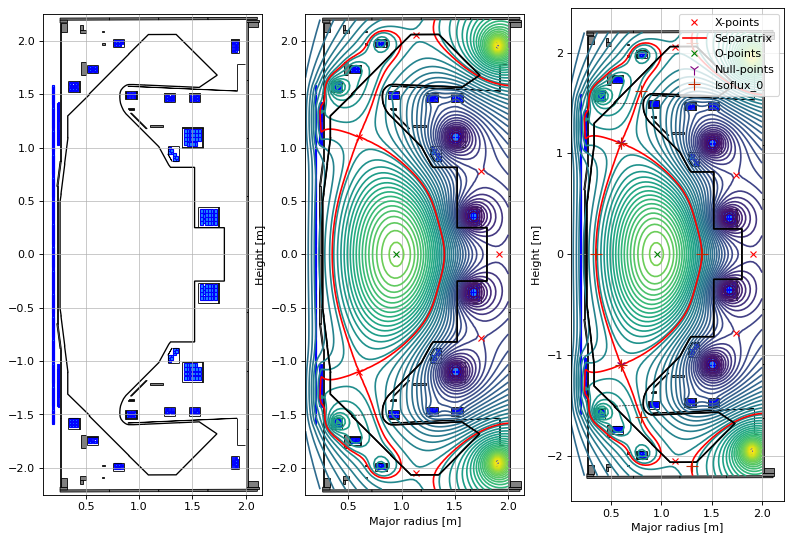

<Figure size 640x480 with 0 Axes>

In [11]:
fig1, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 8), dpi=80)

ax1.grid(zorder=0, alpha=0.75)
ax1.set_aspect('equal')
eq.tokamak.plot(axis=ax1,show=False)                                                          # plots the active coils and passive structures
ax1.fill(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, facecolor='w', zorder=0)   # plots the limiter
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)

ax2.grid(zorder=0, alpha=0.75)
ax2.set_aspect('equal')
eq.tokamak.plot(axis=ax2,show=False)                                                          # plots the active coils and passive structures
ax2.fill(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, facecolor='w', zorder=0)   # plots the limiter
eq.plot(axis=ax2,show=False)                                                                  # plots the equilibrium
ax2.set_xlim(0.1, 2.15)
ax2.set_ylim(-2.25, 2.25)


ax3.grid(zorder=0, alpha=0.75)
ax3.set_aspect('equal')
eq.tokamak.plot(axis=ax3,show=False)                                                          # plots the active coils and passive structures
ax3.fill(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, facecolor='w', zorder=0)   # plots the limiter
eq.plot(axis=ax3,show=False)                                                                  # plots the equilibrium
constrain.plot(axis=ax3, show=True)                                                          # plots the contraints
ax3.set_xlim(0.1, 2.15)
ax3.set_ylim(-2.25, 2.25)

plt.tight_layout()

A solve call will modify the equilibrium object in place. That means that certain quantities within the object will be updated as a result of the solve. 

Various different quantities and functions can be accessed via the 'eq' and 'profile' objects. For example:
- the total flux can be accessed with `eq.psi()`.
- the plasma flux with `eq.plasma_psi`.
- the active coil + passive structure flux with `eq.tokamak.psi(eq.R, eq.Z)`.
- (Total flux = plasma flux + coil flux)

Explore `eq.` to see more (also `profiles.`, e.g. the plasma current distribution over the domain can be found with `profiles.jtor`).

The set of optimised coil currents can be retrieved using `eq.tokamak.getCurrents()` having been assigned to the equilibrium object during the inverse solve.

The following lines will save the calculated currents to a pickle file (we will use these in future notebooks). 

In [12]:
inverse_current_values = eq.tokamak.getCurrents()

# save coil currents to file
import pickle
with open('simple_diverted_currents_PaxisIp.pk', 'wb') as f:
    pickle.dump(obj=inverse_current_values, file=f)

### Second inverse solve: limited plasma example

Below we carry out an inverse solve seeking coil current values for a limited plasma configuration (rather than a diverted one). 

In a limiter configuration the plasma "touches" the limiter of the tokamak and is confined by the solid structures of the vessel. The last closed flux surface (LCFS) is the closed contour that is furthest from the magnetic axis that just barely touches (and is tangent to) the limiter.

We instantiate a new equilibrium but use the same profile object, and illustrate how to vary the total plasma current and pressure on axis within it. 

In [13]:
# reset the coil currents and equilibrium
# tokamak = build_machine.tokamak()
eq = equilibrium_update.Equilibrium(
    tokamak=tokamak,      # provide tokamak object
    Rmin=0.1, Rmax=2.0,   # radial range
    Zmin=-2.2, Zmax=2.2,  # vertical range
    nx=65,                # number of grid points in the radial direction (needs to be of the form (2**n + 1) with n being an integer)
    ny=129,               # number of grid points in the vertical direction (needs to be of the form (2**n + 1) with n being an integer)
    # psi=plasma_psi
)

# first we specify some alterantive constraints
Rout = 1.4   # outboard midplane radius
Rin = 0.24   # inboard midplane radius

# locations of X-points
Rx = 0.45
Zx = 1.18
null_points = [[Rx, Rx], [Zx, -Zx]]


# isoflux constraints
isoflux_set = [[Rx, Rx, Rout, Rin, Rin, Rin, Rin, Rin, .75, .75, .85, .85, 1.3, 1.3],
           [Zx, -Zx,  0,  0,  .1, -.1, .2, -.2, 1.6, -1.6, 1.7, -1.7, 2.1, -2.1]]


# let's seek an up-down symmetric equilibrium by imposing the current in P6 is zero
#eq.tokamak.set_coil_current('P6', 0)
#eq.tokamak['P6'].control = False # fixes the current

# let's assume we're also seeking an equilibrium with no solenoid current
eq.tokamak.set_coil_current('Solenoid', 0)
eq.tokamak['Solenoid'].control = False # fixes the current

# pass the magnetic constraints to a new constrain object
constrain = Inverse_optimizer(null_points=null_points,
                              isoflux_set=isoflux_set)

# modify the total plasma current
profiles.Ip = 4e5

# modify the pressure on the magnetic axis
profiles.paxis = 6e3

GSStaticSolver.solve(eq=eq, 
                     profiles=profiles, 
                     constrain=constrain, 
                     target_relative_tolerance=1e-6,
                     target_relative_psit_update=1e-3,
                     verbose=True, # print output
                     l2_reg=np.array([1e-12]*10+[1e-6]), 
                     )

Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.0196
Current updates: [ 8.99242989e+01  1.91778209e+01  3.36481029e+02  4.04222659e+02
 -2.25421310e+02  3.53120315e+02 -3.11579167e+02 -1.57409314e+02
 -5.43428541e+02  1.87827245e+02 -6.91585768e-11]
Magnetic constraint losses = 0.8795307009189297
Handing off to forward_solve. Requested tolerance: 0.000196
Discarding 'primary' Xpoint! Please check final result
Iteration 1 complete.
---
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.019208
Current updates: [ 8.90951521e+01  1.32021765e+01  3.60312431e+02  4.34788672e+02
 -2.41891032e+02  3.76731273e+02 -3.35254692e+02 -1.69950878e+02
 -5.83529347e+02  2.05624589e+02 -8.37329389e-11]
Magnetic constraint losses = 0.7760775425937406
Handing off to forward_solve. Requested tolerance: 0.00019208
Discarding 'primary' Xpoint! Please check final result
Iteration 2 comple

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 0.000196 with less than 1 iterations. Last relative psi change: 0.964108966587941.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 0.00019208 with less than 1 iterations. Last relative psi change: 0.9554332784781798.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 0.00018823839999999997 with less than 1 iterations. Last relative psi change: 0.946076951282207.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 0.000184473

Iteration 9 complete.
---
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.016341456137750933
Current updates: [-3.02305644e+02 -6.50061620e+02  1.53885090e+03  1.96132533e+03
 -1.02773880e+03  1.45658122e+03 -1.55601173e+03 -8.36130033e+02
 -2.57194543e+03  1.32914329e+03 -1.96792009e-09]
Magnetic constraint losses = 0.1545933957293599
Handing off to forward_solve. Requested tolerance: 0.00016341456137750933
Iteration 10 complete.
---
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.009383125765502901
Current updates: [-7.96124106e+02 -1.15570906e+03  1.30913922e+03  1.66661227e+03
 -8.20265260e+02  1.10666276e+03 -1.39972791e+03 -7.79563005e+02
 -2.18606825e+03  1.48842008e+03 -4.38047590e-09]
Magnetic constraint losses = 0.07830882312199368
Handing off to forward_solve. Requested tolerance: 9.383125765502902e-05
Iteration 11 complete.
---
Using Greens' Jacobian

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 6.732916660301942e-05 with less than 1 iterations. Last relative psi change: 0.5909668185456735.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 6.681213462015585e-05 with less than 1 iterations. Last relative psi change: 0.5398732042031626.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 6.513279779368426e-05 with less than 1 iterations. Last relative psi change: 0.48362677432204826.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relativ

Iteration 18 complete.
---
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.010021820193023378
Current updates: [-1.54870728e+02 -1.27708512e+02 -6.25892932e+02 -6.90798511e+02
  3.79632751e+02 -6.29987114e+02  5.54231779e+02  2.80413917e+02
  9.64976256e+02 -3.22198812e+02 -3.72427249e-09]
Magnetic constraint losses = 0.027738754858929578
Handing off to forward_solve. Requested tolerance: 6.681213462015585e-05
Iteration 19 complete.
---
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.00976991966905264
Current updates: [-1.45303281e+02 -1.15989742e+02 -5.69281348e+02 -6.27110514e+02
  3.44739116e+02 -5.72441175e+02  5.03710005e+02  2.54490602e+02
  8.75445362e+02 -2.99804460e+02 -3.64951558e-09]
Magnetic constraint losses = 0.02550612978762742
Handing off to forward_solve. Requested tolerance: 6.513279779368426e-05
Iteration 20 complete.
---
Using Greens' Jacobia

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 8.657551637738544e-06 with less than 5 iterations. Last relative psi change: 1.0804548429191985e-05.
  warnings.warn(


Iteration 35 complete.
---
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.00787157558688269
Current updates: [ 6.43459827e+01 -1.52197939e+01 -2.15269391e+01 -4.39297008e+01
  2.16913127e+01 -2.72570936e+01  2.57218579e+01  1.86309355e+01
  6.57608126e+01  6.21044002e+01 -3.94745765e-06]
Magnetic constraint losses = 0.012624858722299221
Handing off to forward_solve. Requested tolerance: 6.910573903436107e-06
Forward static solve complete. Last relative residual: 1.2394004776810802e-06
 
Iteration 36 complete.
---
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.008612557505490172
Current updates: [-6.53807421e+01  1.52718244e+01  2.19808782e+01  4.42857481e+01
 -2.30563255e+01  2.54356502e+01 -2.54168636e+01 -1.83163908e+01
 -6.29742698e+01 -6.13880802e+01 -4.17193578e-07]
Magnetic constraint losses = 0.012675496090617602
Handing off to forward_solve. Requested 

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 5.04072867262342e-06 with less than 5 iterations. Last relative psi change: 7.114288498637161e-06.
  warnings.warn(


Iteration 37 complete.
---
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.00735113503665263
Current updates: [ 6.08621378e+01 -1.44084034e+01 -1.97718522e+01 -4.12228884e+01
  2.03755649e+01 -2.50405980e+01  2.39333852e+01  1.74453080e+01
  6.13393840e+01  5.77639666e+01 -2.68267748e-06]
Magnetic constraint losses = 0.012255905649656644
Handing off to forward_solve. Requested tolerance: 4.3024475751784935e-06
Forward static solve complete. Last relative residual: 1.695427622855034e-06
 
Iteration 38 complete.
---
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.007303471014291553
Current updates: [-5.55895148e+01  1.30237650e+01  1.90648648e+01  3.78609743e+01
 -1.97867170e+01  2.18956344e+01 -2.18542269e+01 -1.56721706e+01
 -5.38339954e+01 -5.22037048e+01 -1.93455976e-07]
Magnetic constraint losses = 0.011251573797372757
Handing off to forward_solve. Requested 

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 3.418124299221206e-06 with less than 5 iterations. Last relative psi change: 3.4394697923021955e-06.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 3.049725069413092e-06 with less than 5 iterations. Last relative psi change: 5.666345923856792e-06.
  warnings.warn(


Iteration 41 complete.
---
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.003964796167009913
Current updates: [ 3.17317096e+01 -7.43245373e+00 -9.78640889e+00 -2.11938885e+01
  1.02233060e+01 -1.30215658e+01  1.22177728e+01  9.02026197e+00
  3.20661083e+01  3.06314916e+01 -5.96715529e-06]
Magnetic constraint losses = 0.007050104338324683
Handing off to forward_solve. Requested tolerance: 2.320502557737855e-06
Iteration 42 complete.
---
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.003237253216054854
Current updates: [-2.50315273e+01  5.68639124e+00  8.46462346e+00  1.65209680e+01
 -8.89792686e+00  9.52356649e+00 -9.44434520e+00 -6.74979404e+00
 -2.31990162e+01 -2.45742595e+01 -1.20354109e-06]
Magnetic constraint losses = 0.005651055734803655
Handing off to forward_solve. Requested tolerance: 1.8946886678327449e-06


/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 2.320502557737855e-06 with less than 5 iterations. Last relative psi change: 4.168650395783607e-06.
  warnings.warn(


Forward static solve complete. Last relative residual: 2.22350156853525e-07
 
Iteration 43 complete.
---
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.0023371497682806667
Current updates: [ 1.84096366e+01 -4.30528079e+00 -5.31040922e+00 -1.20861506e+01
  5.62424779e+00 -7.59266010e+00  6.93150086e+00  5.19797218e+00
  1.87627084e+01  1.80502691e+01 -2.42036674e-08]
Magnetic constraint losses = 0.00437867830557387
Handing off to forward_solve. Requested tolerance: 1.3678791510741899e-06
Forward static solve complete. Last relative residual: 1.8358971250371883e-07
 
Iteration 44 complete.
---
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.00172961666768457
Current updates: [-1.35206509e+01  3.04990661e+00  4.86315572e+00  9.01484685e+00
 -5.05269701e+00  5.06827211e+00 -5.15256786e+00 -3.61509324e+00
 -1.22224122e+01 -1.33360075e+01 -1.40336899e-07]
Magnetic co

In [14]:
# save the currents for later use
inverse_current_values = eq.tokamak.getCurrents()

# save coil currents to file
with open('simple_limited_currents_PaxisIp.pk', 'wb') as f:
    pickle.dump(obj=inverse_current_values, file=f)

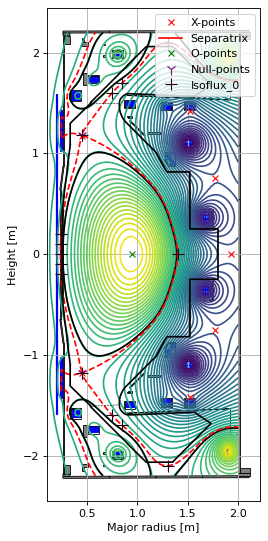

<Figure size 640x480 with 0 Axes>

In [15]:
# plot the resulting equilbria 
fig1, ax1 = plt.subplots(1, 1, figsize=(4, 8), dpi=80)
ax1.grid(True, which='both')
eq.plot(axis=ax1, show=False)
eq.tokamak.plot(axis=ax1, show=False)
constrain.plot(axis=ax1,show=True)
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)
plt.tight_layout()

Now, let's assume we wish to set the solenoid current to 40000 Amperes. We can do so starting from the equilibrium we just built and adding a 'curr_vals' constraint to the constrain object.
This will add a term to the loss connected to the value of the Solenoid current.

In [16]:
# curr_vals constraints are of the form
# [coil indexes in the array of coils available for control, coil current values]
# in this case we're controlling the Solenoid:
curr_vals = [[0], [40000.]]

# add the constraints to a new freegsnke Inverse_optimizer object
constrain = Inverse_optimizer(null_points=null_points,
                              isoflux_set=isoflux_set,
                              curr_vals=curr_vals)

# remember to switch ON the control of the Solenoid, which was previously OFF!
eq.tokamak['Solenoid'].control = True

In [17]:
# carry out the inverse solve
GSStaticSolver.solve(eq=eq, 
                     profiles=profiles, 
                     constrain=constrain, 
                     target_relative_tolerance=1e-6,
                     target_relative_psit_update=1e-3,
                     max_solving_iterations=150,
                     force_up_down_symmetric=True,
                     verbose=True,
                     )

Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.02
Current updates: [ 7.27326593e+02  8.15974677e+00  2.76229021e+01  2.41408443e+01
  3.04921034e+01  3.52385880e+01  3.91036990e+01  2.81254546e+01
  2.65191999e+01  1.10136695e+01 -1.30095893e+01 -3.20281698e-05]
Magnetic constraint losses = 69282.03327050919
Handing off to forward_solve. Requested tolerance: 0.0002
Iteration 1 complete.
---
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.02
Current updates: [ 7.00592344e+02  8.01611052e+00  2.68354796e+01  2.33503946e+01
  2.94724821e+01  3.39388362e+01  3.78152823e+01  2.70932769e+01
  2.55680868e+01  1.05241076e+01 -1.26435453e+01  9.56324739e-08]
Magnetic constraint losses = 68022.2675700663
Handing off to forward_solve. Requested tolerance: 0.0002
Forward static solve complete. Last relative residual: 4.295496105304406e-05
 
Iteration 2 complete.
---
Using 

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 0.0002 with less than 1 iterations. Last relative psi change: 0.0002690327099629946.
  warnings.warn(


Forward static solve complete. Last relative residual: 5.366371917850205e-05
 
Iteration 4 complete.
---
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.02
Current updates: [ 6.32986863e+02  7.65052447e+00  2.48523214e+01  2.13603288e+01
  2.69073440e+01  3.06674537e+01  3.45669115e+01  2.44891787e+01
  2.31627119e+01  9.26472508e+00 -1.18290327e+01  9.06355685e-08]
Magnetic constraint losses = 64506.20508858938
Handing off to forward_solve. Requested tolerance: 0.0002
Forward static solve complete. Last relative residual: 6.345899552911417e-05
 
Iteration 5 complete.
---
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.019999999999999997
Current updates: [ 6.14384479e+02  7.56001043e+00  2.43171792e+01  2.08151853e+01
  2.62036430e+01  2.97601839e+01  3.36784777e+01  2.37686641e+01
  2.24997370e+01  8.91398251e+00 -1.15947709e+01  8.93409680e-08]
Magnetic constr

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 5 iterations. Last relative psi change: 1.2669158963829338e-06.
  warnings.warn(


Forward static solve complete. Last relative residual: 5.910426439751493e-07
 
Iteration 62 complete.
---
Static solve complete.
Last update to the control currents caused a relative update of tokamak_psi in the core of: 0.0007834490257271143.
Last relative GS residual: 5.910426439751493e-07


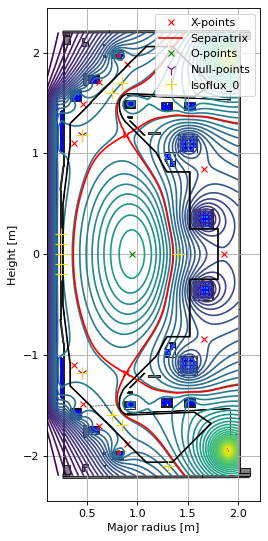

<Figure size 640x480 with 0 Axes>

In [21]:
# plot the resulting equilbria 
fig1, ax1 = plt.subplots(1, 1, figsize=(4, 8), dpi=80)
ax1.grid(True, which='both')
eq.plot(axis=ax1, show=False)
eq.tokamak.plot(axis=ax1, show=False)
constrain.plot(axis=ax1,show=True)
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)
plt.tight_layout()

In [19]:
# finally, let's check the Solenoid current:
eq.tokamak['Solenoid'].current

39999.99999991388